In [1]:
# Required Packages
import numpy as np
import pandas as pd
import wfdb
import pywt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(42)

# Path to MIT-BIH data
data = 'mitdb/'

# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

# Abnormal & Normal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']
normal = ['N']

# Wavelet denoising
def wavelet_denoising(signal, wavelet='db6', level=1):
    coeff = pywt.wavedec(signal, wavelet, mode='per')
    sigma = np.median(np.abs(coeff[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeff[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:]]
    return pywt.waverec(coeff, wavelet, mode='per')

# Apply denoising to dataset
def denoise_ecg_signals(signals):
    return np.array([wavelet_denoising(signal) for signal in signals])

# Load ECG signal & annotation
def load_ecg(file):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal[:, 0]  # First channel
    return p_signal, annotation.symbol, annotation.sample

# Extract X (ECG segment), Y (label), sym (beat symbol)
def build_XY(p_signal, df_ann, num_cols, abnormal):
    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows, 1))
    sym = []
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values, df_ann.atr_sym.values):
        left = max(0, atr_sample - num_sec * fs)
        right = min(len(p_signal), atr_sample + num_sec * fs)
        x = p_signal[left:right]
        if len(x) == num_cols:
            X[max_row, :] = x
            Y[max_row, :] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1

    return X[:max_row, :], Y[:max_row, :], sym

# Create dataset from all patients
def make_dataset(patients, num_sec, fs, abnormal):
    num_cols = 2 * num_sec * fs
    X_all = []
    Y_all = []
    sym_all = []

    for pt in patients:
        file = data + pt
        p_signal, atr_sym, atr_sample = load_ecg(file)
        df_ann = pd.DataFrame({'atr_sym': atr_sym, 'atr_sample': atr_sample})
        df_ann = df_ann[df_ann.atr_sym.isin(abnormal + ['N'])]
        X, Y, sym = build_XY(p_signal, df_ann, num_cols, abnormal)
        if len(X) > 0:
            X_all.append(X)
            Y_all.append(Y)
            sym_all += sym

    X_all = np.vstack(X_all)
    Y_all = np.vstack(Y_all)
    return X_all, Y_all, sym_all

# Parameters
num_sec = 3
fs = 360

# Prepare dataset
X_all, Y_all, sym_all = make_dataset(patients, num_sec, fs, abnormal)

# Denoise
X_all_denoised = denoise_ecg_signals(X_all)

# Normalize
scaler = MinMaxScaler()
X_all_normalized = scaler.fit_transform(X_all_denoised)

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import time


# 14 beat types to classify
beat_types = ['j', 'V', 'f', 'L', 'e', 'R', 'N', '/', 'A', 'a', 'E', 'S', 'F', 'J']

# Filter X and sym_all to include only those beat types
filtered_indices = [i for i, sym in enumerate(sym_all) if sym in beat_types]
X_filtered = X_all_normalized[filtered_indices]
sym_filtered = [sym_all[i] for i in filtered_indices]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(sym_filtered)
y_onehot = to_categorical(y_encoded)

# Reshape X for CNN (samples, timesteps, channels)
X_reshaped = X_filtered.reshape(X_filtered.shape[0], X_filtered.shape[1], 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)

In [3]:
X_train.shape[1]

2160

In [4]:
# Define CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(beat_types), activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Start timer
start_time = time.time()

# Train model
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))

# End timer
end_time = time.time()

# Total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


2025-05-10 00:59:35.286399: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-10 00:59:35.286461: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-10 00:59:35.286474: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-10 00:59:35.286803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-10 00:59:35.286819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2025-05-10 00:59:37.317998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 83s 60ms/step - accuracy: 0.7430 - loss: 0.9892 - val_accuracy: 0.9239 - val_loss: 0.2900
Epoch 2/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 80s 59ms/step - accuracy: 0.9106 - loss: 0.3330 - val_accuracy: 0.9522 - val_loss: 0.1938
Epoch 3/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9260 - loss: 0.3110 - val_accuracy: 0.9566 - val_loss: 0.2016
Epoch 4/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9259 - loss: 0.3534 - val_accuracy: 0.9603 - val_loss: 0.2636
Epoch 5/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.9233 - loss: 0.4904 - val_accuracy: 0.9577 - val_loss: 0.4591
Epoch 6/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.9260 - loss: 0.6952 - val_accuracy: 0.9629 - val_loss: 0.4290
Epoch 7/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.9245 - loss: 1.0647 - val_accuracy: 0.9646 - val_loss: 0.5630
Epoch 8/15
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.9283 - loss: 1.50

In [5]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Decode predictions if needed
import numpy as np
pred_labels = np.argmax(model.predict(X_test), axis=1)
decoded_preds = label_encoder.inverse_transform(pred_labels)

682/682 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9725 - loss: 9.9507
Test Accuracy: 97.05%
682/682 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


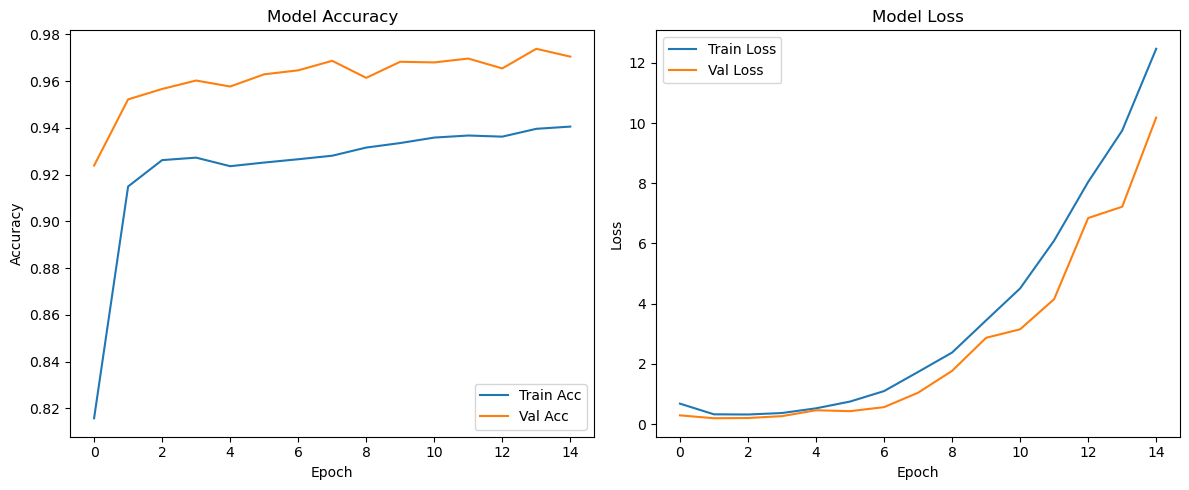

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

682/682 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step

📊 Evaluation Metrics:
Accuracy  : 0.9705
Precision : 0.7087
Recall    : 0.5949
F1-score  : 0.6270



Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9872    0.9936    0.9904      1400
           1     0.9803    0.6884    0.8088       507
           2     0.9091    0.9524    0.9302        21
           3     0.8413    0.3312    0.4753       160
           4     0.0000    0.0000    0.0000        17
           5     0.9770    0.9777    0.9774      1611
           6     0.9673    0.9984    0.9826     14959
           7     0.9917    0.9869    0.9893      1447
           9     0.9709    0.8911    0.9293      1423
          10     0.6667    0.1333    0.2222        30
          11     0.0000    0.0000    0.0000         3
          12     0.9217    0.7806    0.8453       196
          13     0.0000    0.0000    0.0000        46

    accuracy                         0.9705     21820
   macro avg     0.7087    0.5949    0.6270     21820
weighted avg     0.9667    0.9705    0.9666     21820



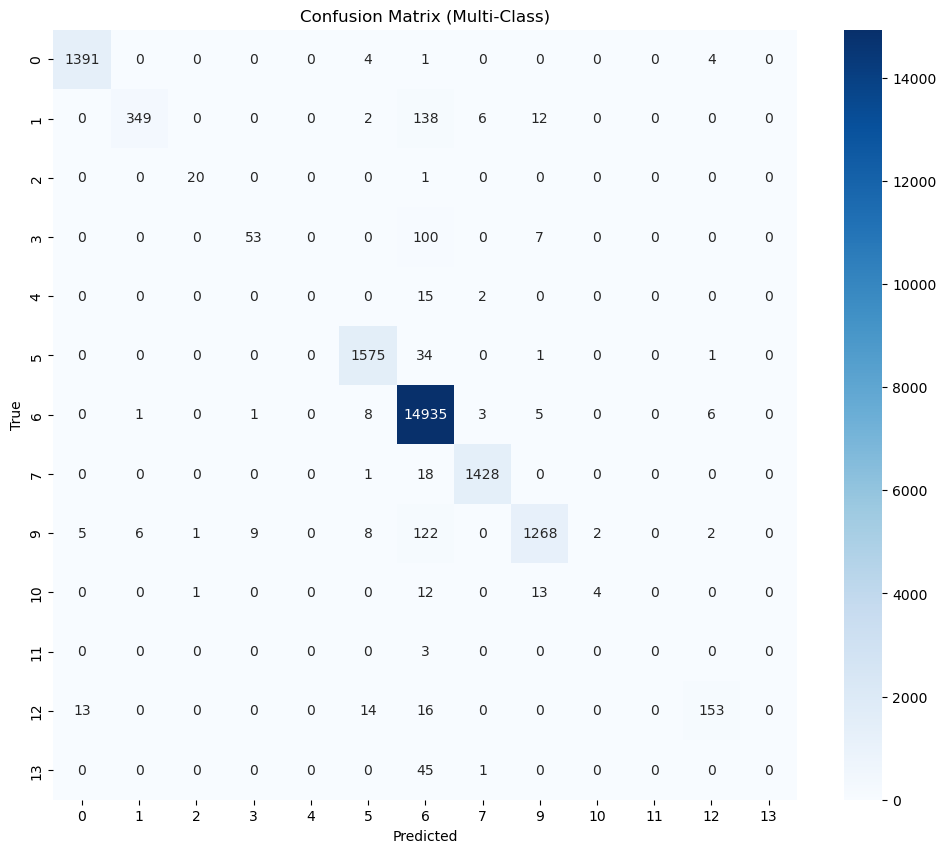

In [8]:
# Optional: Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
class_labels = list(range(14))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multi-Class)')
plt.show()

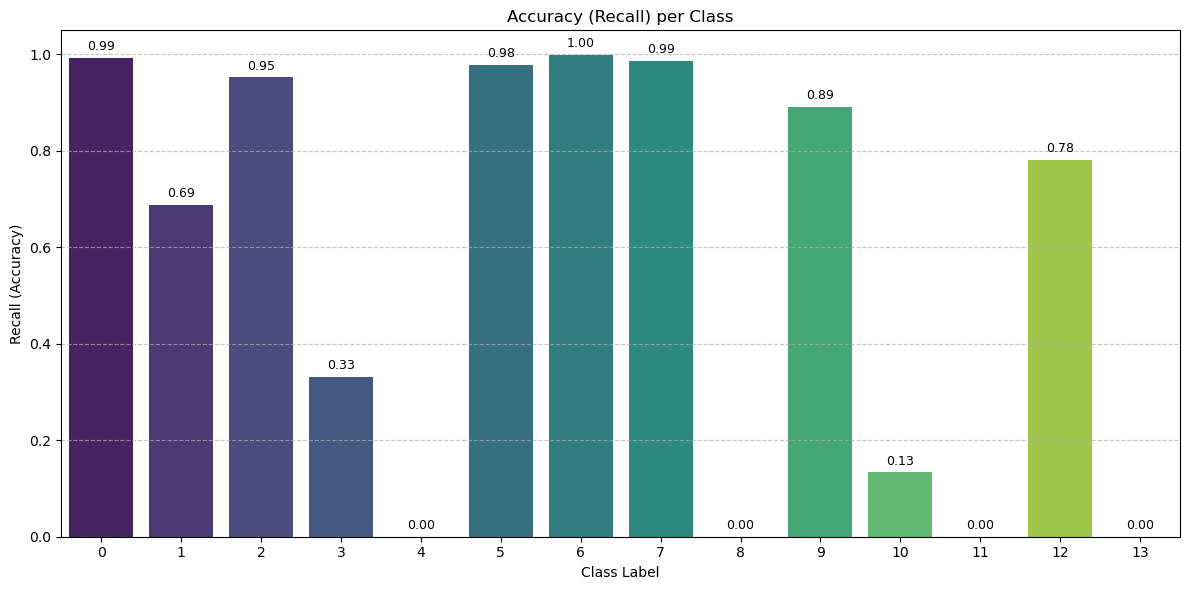

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class labels (0–13)
class_labels = list(range(14))

# Recall values (from your classification report)
recall_per_class = [
    0.9936,0.6884,0.9524,0.3312,0.0000,0.9777,0.9984,0.9869,0,0.8911,0.1333,0.0000,0.7806,0.0000
]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')
plt.title('Accuracy (Recall) per Class')
plt.xlabel('Class Label')
plt.ylabel('Recall (Accuracy)')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, rec in enumerate(recall_per_class):
    plt.text(i, rec + 0.01, f"{rec:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()